# 🔍 Pairwise Johansen Cointegration Analysis — Introduction & Analyst Insights

## Overview

This notebook implements a **systematic pairwise Johansen cointegration framework** for multi-asset price data. It automates the full workflow — from lag selection to interpretation — providing analysts and quants a **credible and statistically rigorous foundation** for identifying long-term equilibrium relationships between assets.

The implementation follows the econometric standards used in academic and institutional quantitative research. It extends the traditional Engle–Granger approach by leveraging the **Johansen multivariate method**, which is **more powerful and robust** in detecting cointegration when dealing with multiple non-stationary time series.

---

## What this code does

1. **Runs Johansen’s Cointegration Test** (`coint_johansen`) on *every asset pair* in the input price matrix.
2. **Automatically selects optimal lags** using **VAR-based AIC** — ensuring statistical robustness and avoiding overfitting.
3. **Collects and structures** the main test statistics — eigenvalues, trace, and max-eigenvalue metrics — along with their 95% critical values.
4. **Determines cointegration status** from both the **trace** and **max-eigen** test perspectives.
5. **Extracts and normalizes** the cointegrating vector for each valid pair, yielding interpretable spread equations.
6. **Produces a tidy summary table** with statistical insights and ** interpretations**, enabling quick scanning and prioritization of promising pairs.
7. **Optional visualization helpers** plot the cointegrating spread and z-score, allowing intuitive inspection of mean-reverting dynamics.

---

## Why this matters (Key analytical insights)

- 📈 **Detects stable long-run relationships** — Johansen’s framework reveals when assets move together in equilibrium despite short-term deviations.  
- ⚙️ **Improves signal credibility** — By relying on two complementary tests (trace & max-eigenvalue), results are statistically defensible and transparent.  
- 🔄 **Enables robust pairs trading ideas** — Cointegrated pairs form the basis for mean-reversion strategies, statistical arbitrage, and hedged long-short exposures.  
- 🔬 **Lag & deterministic term optimization** — Built-in lag selection via AIC and flexible deterministic components (constant/trend) make the test robust to structural features of financial time series.  
- 🧠 **Econometric transparency** — Output metrics (eigenvalues, trace, max-eig) can be directly interpreted, ensuring that results are explainable and auditable — not black-box.  
- 🪙 **Scalable to multiple assets** — The pairwise implementation makes it easy to scan dozens of tickers and quickly shortlist statistically significant relationships.

---

## Credibility & methodological soundness

- **Academic foundation:** Based on Johansen (1988, 1991) methodology for maximum-likelihood estimation of cointegrating vectors in VAR systems.  
- **Statistical rigor:** Uses **asymptotic critical values** and standard 95% rejection thresholds as per the original Johansen tables.  
- **Industry use:** Cointegration tests are a cornerstone of quantitative finance for identifying pairs or baskets that exhibit *mean-reverting* relationships, widely applied in hedge funds, proprietary trading, and risk management.  
- **Reproducibility:** All metrics and model settings (lags, deterministic order, critical values) are explicitly logged for auditability.  
- **Interpretability:** Outputs are readable, emphasizing transparency over automation — ensuring analysts understand *why* two assets are or aren’t cointegrated.

---

## Key Takeaways for Analysts

- ✅ **Two strong pairs identified** (GLD–HDFCBANK.NS, GLD–RELIANCE.NS) — statistically robust cointegration across both tests.  
- ⚠️ **Three borderline pairs** (GLD–^NSEI, GLD–ICICIBANK.NS, GLD–ONGC.NS) — mixed evidence, requiring robustness and visual checks.  
- ❌ **Others** show no significant long-run equilibrium — treat as uncorrelated or only short-term correlated.

---

### 💡 In short:
This framework gives you a **quantitatively credible, auditable, and ready-to-deploy pipeline** for discovering, validating, and prioritizing cointegrated asset pairs — the critical first step in designing **market-neutral, mean-reversion trading strategies** grounded in sound econometric evidence.


# Johansen Pairwise Cointegration — Results, Interpretation & Actionable Findings

> **Notes on reading the table**
>
> - **eig1, eig2**: Johansen eigenvalues (descending). Larger eig1 → stronger first cointegrating relation (roughly the squared canonical correlation for the first vector).  
> - **trace_stat_r0 / trace_crit95_r0**: Compare — if `trace_stat_r0 > trace_crit95_r0` ⇒ reject H₀: rank = 0 (trace test says *≥1* CI vector).  
> - **maxeig_stat_r0 / maxeig_crit95_r0**: Compare — if `maxeig_stat_r0 > maxeig_crit95_r0` ⇒ reject H₀: rank = 0 (max-eig test says *1* CI vector).  
> - **rank_trace / rank_maxeig**: Ranks implied by iterative comparisons at 95% critical values.  
> - **beta_y_normalized**: cointegrating vector normalized so coefficient on `x` = 1. The (approx) cointegrating relation is  
>   `beta_y_normalized * y + 1 * x = 0` → `spread = beta_y_normalized * y + x`.  
>   (Flip sign if you prefer `y - gamma*x`.)

---


In [1]:
# Johansen pairwise analysis — run across all pairs and report results
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
import pandas as pd
import numpy as np
import itertools

import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import os
from datetime import datetime
import itertools


from statsmodels.tsa.stattools import adfuller

In [6]:

# ---------------------------
# 1️⃣ Fetch Adjusted Close Data
# ---------------------------
def fetch_adjusted_close(ticker_list, start="2015-01-01", end=None):
    """
    Fetch Adjusted Close prices from Yahoo Finance.
    Works robustly whether you pass one or multiple tickers.
    """
    data = yf.download(ticker_list, start=start, end=end, auto_adjust=False, progress=False, group_by='ticker', threads=True)

    # Single ticker case
    if isinstance(ticker_list, str) or len(ticker_list) == 1:
        if 'Adj Close' in data.columns:
            prices = data['Adj Close'].to_frame()
            prices.columns = [ticker_list if isinstance(ticker_list, str) else ticker_list[0]]
            return prices
        elif 'Close' in data.columns:
            print("⚠️ Using 'Close' instead of 'Adj Close'")
            prices = data['Close'].to_frame()
            prices.columns = [ticker_list if isinstance(ticker_list, str) else ticker_list[0]]
            return prices
        else:
            raise KeyError("Neither 'Adj Close' nor 'Close' found.")

    # Multi-ticker case
    if isinstance(data.columns, pd.MultiIndex):
        if ('Adj Close' in data.columns.get_level_values(1)):
            prices = data.xs('Adj Close', axis=1, level=1)
        elif ('Close' in data.columns.get_level_values(1)):
            print("⚠️ Using 'Close' instead of 'Adj Close'")
            prices = data.xs('Close', axis=1, level=1)
        else:
            raise KeyError("Neither 'Adj Close' nor 'Close' found in dataset.")
    else:
        if 'Adj Close' in data.columns:
            prices = data[['Adj Close']]
        elif 'Close' in data.columns:
            prices = data[['Close']]
        else:
            raise KeyError("No valid price columns found.")

    prices = prices.dropna(how='all')
    prices.columns = [c if isinstance(c, str) else c[0] for c in prices.columns]
    return prices

# Tickers to test
tickers = ['GLD', 'HDFCBANK.NS', 'ICICIBANK.NS', 'ONGC.NS', 'RELIANCE.NS', '^NSEI']
prices = fetch_adjusted_close(tickers, start="2018-01-01")
#prices.tail()

def select_k_ar_diff(df, maxlags=8):
    """
    Select VAR lag order by AIC and convert to k_ar_diff = p - 1 for Johansen.
    Returns at least 1 (k_ar_diff >= 1).
    """
    try:
        sel = VAR(df).select_order(maxlags=maxlags)
        # sel.selected_orders is a dict-like with keys 'aic','bic','hqic','fpe'
        p = None
        if hasattr(sel, 'aic'):
            p = sel.aic
        elif isinstance(sel.selected_orders, dict) and 'aic' in sel.selected_orders:
            p = sel.selected_orders['aic']
        # fallback:
        if p is None or np.isnan(p):
            p = 2
        k_ar_diff = int(max(1, p - 1))
    except Exception as e:
        # on any error fall back to 1
        k_ar_diff = 1
    return k_ar_diff

def run_johansen_for_pair(series_y, series_x, det_order=0, maxlags=8):
    """
    Runs coint_johansen on the 2-series dataset [y, x].
    det_order: -1 (no deterministic), 0 (constant), 1 (linear trend)
    Returns a dict with important diagnostics.
    """
    df = pd.concat([series_y, series_x], axis=1).dropna()
    df.columns = ['y', 'x']
    if len(df) < 40:  # small-sample guard
        # still attempt but warn user
        pass

    k_ar_diff = select_k_ar_diff(df, maxlags=maxlags)

    # Johansen expects nobs x neqs array (with presample) -> we pass the dataframe values
    joh = coint_johansen(df.values, det_order, k_ar_diff)

    # Results:
    eigvals = joh.eig            # eigenvalues (lambda_i)
    evecs = joh.evec            # eigenvectors (columns are eigenvectors)
    trace_stats = joh.lr1       # trace statistics for r = 0..n-1
    maxe_stats = joh.lr2        # max eigenvalue statistics for r = 0..n-1
    trace_crit = joh.cvt        # critical values for trace (shape n x 3) (90%,95%,99%)
    maxe_crit = joh.cvm         # critical values for max eig (shape n x 3)  (90%,95%,99%)

    # For a 2-variable system: we will look at r=0 vs r>=1 (rows index 0) mainly.
    # Determine rank by comparing statistics with 95% critical values (index 1)
    rank_trace = 0
    for r, stat in enumerate(trace_stats):
        crit_95 = trace_crit[r, 1]
        if stat > crit_95:
            rank_trace = r + 1  # because trace stat at index r tests H0: rank = r
        else:
            break

    rank_maxeig = 0
    for r, stat in enumerate(maxe_stats):
        crit_95 = maxe_crit[r, 1]
        if stat > crit_95:
            rank_maxeig = r + 1
        else:
            break

    # Extract primary cointegrating vector (for n=2 we generally take eigenvector corresponding to largest eig)
    # Statsmodels returns evecs as columns corresponding to eigenvalues in descending order.
    top_evec = evecs[:, 0]  # first eigenvector
    # Normalize cointegrating vector so that coefficient on the second series (x) = 1 (if nonzero)
    if abs(top_evec[1]) > 1e-8:
        coin_vec = top_evec / top_evec[1]
    else:
        # fallback normalize by max abs
        coin_vec = top_evec / np.sign(top_evec[0]) / (abs(top_evec[0]) + 1e-10)

    # Build human-readable diagnostic
    cointegrated_by_trace = rank_trace >= 1
    cointegrated_by_maxeig = rank_maxeig >= 1
    strong_eig = eigvals[0]  # higher eigenvalue -> stronger cointegration

    return {
        'nobs': len(df),
        'k_ar_diff': k_ar_diff,
        'eigvals': eigvals,
        'evecs': evecs,
        'top_cointegrating_vector_raw': top_evec,
        'cointegrating_vector_norm': coin_vec,  # normalized so second variable coeff = 1
        'trace_stats': trace_stats,
        'trace_crit': trace_crit,
        'maxe_stats': maxe_stats,
        'maxe_crit': maxe_crit,
        'rank_trace': rank_trace,
        'rank_maxeig': rank_maxeig,
        'cointegrated_by_trace': cointegrated_by_trace,
        'cointegrated_by_maxeig': cointegrated_by_maxeig,
        'strong_eig': strong_eig,
    }

# Run across all pairs in `prices` (you already fetched it earlier)
pairs = list(itertools.combinations(prices.columns, 2))
rows = []
for a, b in pairs:
    try:
        res = run_johansen_for_pair(prices[a], prices[b], det_order=0, maxlags=8)
        # For display: normalize vector corresponds to beta = [beta_y, 1] for the relation beta'y = 0
        beta_norm = res['cointegrating_vector_norm']  # [b_y, 1]
        # For a cointegrated pair, spread = b_y * y + 1 * x  (or depending on signs)
        rows.append({
            'pair': (a, b),
            'nobs': res['nobs'],
            'k_ar_diff': res['k_ar_diff'],
            'eig1': round(res['eigvals'][0], 6),
            'eig2': round(res['eigvals'][1], 6),
            'trace_stat_r0': round(res['trace_stats'][0], 4),
            'trace_crit95_r0': round(res['trace_crit'][0,1], 4),
            'maxeig_stat_r0': round(res['maxe_stats'][0], 4),
            'maxeig_crit95_r0': round(res['maxe_crit'][0,1], 4),
            'rank_trace': res['rank_trace'],
            'rank_maxeig': res['rank_maxeig'],
            'cointegrated_trace': res['cointegrated_by_trace'],
            'cointegrated_maxeig': res['cointegrated_by_maxeig'],
            'beta_y_normalized': float(beta_norm[0]),
            'notes': (
                ("Cointegrated (trace)" if res['cointegrated_by_trace'] else "Not cointegrated (trace)")
                + "; " +
                ("Cointegrated (maxeig)" if res['cointegrated_by_maxeig'] else "Not cointegrated (maxeig)")
            )
        })
    except Exception as e:
        rows.append({'pair': (a,b), 'error': str(e)})

summary_johansen_df = pd.DataFrame(rows)
# reorder columns for readability
cols_order = ['pair','nobs','k_ar_diff','eig1','eig2',
              'trace_stat_r0','trace_crit95_r0','maxeig_stat_r0','maxeig_crit95_r0',
              'rank_trace','rank_maxeig','cointegrated_trace','cointegrated_maxeig',
              'beta_y_normalized','notes','error']
summary_johansen_df = summary_johansen_df[[c for c in cols_order if c in summary_johansen_df.columns]]

# Show sorted by strongest first eigenvalue (descending)
summary_johansen_df = summary_johansen_df.sort_values('eig1', ascending=False).reset_index(drop=True)
display(summary_johansen_df.head())


,pair,nobs,k_ar_diff,eig1,eig2,trace_stat_r0,trace_crit95_r0,maxeig_stat_r0,maxeig_crit95_r0,rank_trace,rank_maxeig,cointegrated_trace,cointegrated_maxeig,beta_y_normalized,notes
0,"(GLD, HDFCBANK.NS)",1860,1,0.009896,0.003534,25.0572,15.4943,18.4788,14.2639,2,2,True,True,-4.313800,Cointegrated (trace); Cointegrated (maxeig)
1,"(GLD, RELIANCE.NS)",1860,1,0.007846,0.001739,17.8687,15.4943,14.6348,14.2639,1,1,True,True,-18.641372,Cointegrated (trace); Cointegrated (maxeig)
2,"(GLD, ^NSEI)",1860,2,0.007777,0.000391,15.2231,15.4943,14.4975,14.2639,0,1,False,True,-478.277123,Not cointegrated (trace); Cointegrated (maxeig)
3,"(GLD, ICICIBANK.NS)",1860,2,0.007737,0.000277,14.9381,15.4943,14.4243,14.2639,0,1,False,True,-105.355009,Not cointegrated (trace); Cointegrated (maxeig)
4,"(GLD, ONGC.NS)",1860,1,0.007649,0.000209,14.6554,15.4943,14.2671,14.2639,0,1,False,True,2.939266,Not cointegrated (trace); Cointegrated (maxeig)


## 1) Tidy results table (pairwise)

| pair | nobs | k_ar_diff | eig1 | eig2 | trace_stat_r0 | trace_crit95_r0 | maxeig_stat_r0 | maxeig_crit95_r0 | rank_trace | rank_maxeig | cointegrated_trace | cointegrated_maxeig | beta_y_normalized | notes |
|---|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|:---:|:---:|---:|---|
| (GLD, HDFCBANK.NS) | 1860 | 1 | 0.009896 | 0.003534 | 25.0572 | 15.4943 | 18.4788 | 14.2639 | 2 | 2 | True | True | -4.313800 | Cointegrated (trace & maxeig). Strongest pair by tests. |
| (GLD, RELIANCE.NS) | 1860 | 1 | 0.007846 | 0.001739 | 17.8687 | 15.4943 | 14.6348 | 14.2639 | 1 | 1 | True | True | -18.641372 | Cointegrated (trace & maxeig). |
| (GLD, ^NSEI) | 1860 | 2 | 0.007777 | 0.000391 | 15.2231 | 15.4943 | 14.4975 | 14.2639 | 0 | 1 | False | True | -478.277123 | **Mixed**: max-eig says cointegrated, trace does not. |
| (GLD, ICICIBANK.NS) | 1860 | 2 | 0.007737 | 0.000277 | 14.9381 | 15.4943 | 14.4243 | 14.2639 | 0 | 1 | False | True | -105.355009 | **Mixed**. |
| (GLD, ONGC.NS) | 1860 | 1 | 0.007649 | 0.000209 | 14.6554 | 15.4943 | 14.2671 | 14.2639 | 0 | 1 | False | True | 2.939266 | **Mixed** (trace no, max-eig yes). |
| (HDFCBANK.NS, ICICIBANK.NS) | 1924 | 4 | 0.006755 | 0.000005 | 13.0169 | 15.4943 | 13.0066 | 14.2639 | 0 | 0 | False | False | -2.653452 | Not cointegrated. |
| (HDFCBANK.NS, ^NSEI) | 1920 | 1 | 0.005303 | 0.000000 | 10.1981 | 15.4943 | 10.1981 | 14.2639 | 0 | 0 | False | False | -38.015827 | Not cointegrated. |
| (^NSEI, ICICIBANK.NS) | 1920 | 3 | 0.004909 | 0.000005 | 9.4391 | 15.4943 | 9.4291 | 14.2639 | 0 | 0 | False | False | -0.072748 | Not cointegrated. |
| (^NSEI, RELIANCE.NS) | 1920 | 1 | 0.004804 | 0.000286 | 9.7853 | 15.4943 | 9.2371 | 14.2639 | 0 | 0 | False | False | -0.049517 | Not cointegrated. |
| (ONGC.NS, RELIANCE.NS) | 1924 | 1 | 0.004396 | 0.000626 | 9.6714 | 15.4943 | 8.4679 | 14.2639 | 0 | 0 | False | False | -3.019531 | Not cointegrated. |
| (ICICIBANK.NS, RELIANCE.NS) | 1924 | 1 | 0.004224 | 0.000213 | 8.5455 | 15.4943 | 8.1352 | 14.2639 | 0 | 0 | False | False | -0.708023 | Not cointegrated. |
| (^NSEI, ONGC.NS) | 1920 | 1 | 0.004036 | 0.000041 | 7.8357 | 15.4943 | 7.7570 | 14.2639 | 0 | 0 | False | False | -0.014393 | Not cointegrated. |
| (HDFCBANK.NS, ONGC.NS) | 1924 | 1 | 0.003969 | 0.000026 | 7.6939 | 15.4943 | 7.6432 | 14.2639 | 0 | 0 | False | False | -0.589126 | Not cointegrated. |
| (HDFCBANK.NS, RELIANCE.NS) | 1924 | 2 | 0.003489 | 0.000853 | 8.3535 | 15.4943 | 6.7148 | 14.2639 | 0 | 0 | False | False | -2.147762 | Not cointegrated. |
| (ICICIBANK.NS, ONGC.NS) | 1924 | 1 | 0.003079 | 0.000056 | 6.0339 | 15.4943 | 5.9272 | 14.2639 | 0 | 0 | False | False | -0.194945 | Not cointegrated. |

---

## 2) Quick interpretations (pair-by-pair)

- **(GLD, HDFCBANK.NS)** — ✅ *Strong evidence of cointegration* (both trace & max-eig reject H₀).  
  - eig1 is the largest among pairs shown (moderate magnitude), trace & max-eig both indicate **rank ≥ 1**.  
  - **Suggested spread** (normalized to x=HDFCBANK.NS): `spread = -4.3138 * GLD + 1 * HDFCBANK.NS`.  
  - **Actionable idea**: build a mean-reversion strategy on the z-score of this spread. Backtest entry/exit thresholds (e.g., ±2σ entry, 0σ exit) and assess hold times & transaction costs.

- **(GLD, RELIANCE.NS)** — ✅ *Strong evidence of cointegration* (both tests agree).  
  - **Suggested spread**: `spread = -18.6414 * GLD + 1 * RELIANCE.NS`.  
  - **Actionable idea**: same mean-reversion approach; be cautious — the large magnitude of `beta_y_normalized` (-18.64) may indicate scaling/units issues or that tiny GLD changes map to large changes in RELIANCE.NS in this normalization. Consider alternative normalization (e.g., normalize by price levels or use log-prices).

- **(GLD, ^NSEI)** — ⚠️ *Mixed evidence* (trace: fail to reject rank=0; max-eig: reject).  
  - **Interpretation**: ambiguous — could be a borderline/weak cointegration or sensitive to lag/deterministic term.  
  - **Actionable idea**: visually inspect spread, run robustness checks: alter `det_order` (none/constant/trend), try different `k_ar_diff` (AIC vs fixed), bootstrap critical values, and check sub-samples.

- **(GLD, ICICIBANK.NS)** — ⚠️ *Mixed evidence* (trace no, max-eig yes). Same recommendations as above.

- **(GLD, ONGC.NS)** — ⚠️ *Mixed evidence* (trace no, max-eig yes). Note `beta_y_normalized` positive (2.939) — interpretation flips sign for spread direction.

- **All other pairs (HDFCBANK.NS vs ICICIBANK.NS, HDFCBANK.NS vs ^NSEI, ^NSEI vs ICICIBANK.NS, etc.)** — ❌ *No evidence of cointegration* (both tests fail to reject H₀ at 95%).  
  - **Actionable idea**: avoid forming pairs strategies on these pairs unless further pre-processing (e.g., industry-adjustment, filtering by log-returns vs levels) reveals a relationship; otherwise treat as non-stationary, unpaired assets.

---

In [3]:
# Quick automated observations and recommended next steps
obs = []
for _, r in summary_johansen_df.iterrows():
    a, b = r['pair']
    msg = f"Pair {a} vs {b}: "
    if r.get('error') is not np.nan and pd.notna(r.get('error')):
        msg += f"ERROR: {r['error']}"
        obs.append(msg); continue

    # Primary consensus: require both tests to agree (optional)
    if r['cointegrated_trace'] and r['cointegrated_maxeig']:
        msg += "✅ Strong evidence of cointegration (both trace & max-eig agree)."
        # strength judgement
        if r['eig1'] > 0.3:
            msg += " (strong eigval)"
        else:
            msg += " (weak-moderate eigval)"
        msg += f" Suggested spread: spread = {r['beta_y_normalized']:.4f} * {a} + 1 * {b}."
        msg += " Consider building a mean-reversion strategy on zscore of this spread."
    elif r['cointegrated_trace'] or r['cointegrated_maxeig']:
        msg += "⚠️ Mixed evidence (one test rejects H0, the other does not). Inspect visually and check sample size/lag choice."
    else:
        msg += "❌ No evidence of cointegration."

    obs.append(msg)

for m in obs:
    print(m)


Pair GLD vs HDFCBANK.NS: ✅ Strong evidence of cointegration (both trace & max-eig agree). (weak-moderate eigval) Suggested spread: spread = -4.3138 * GLD + 1 * HDFCBANK.NS. Consider building a mean-reversion strategy on zscore of this spread.
Pair GLD vs RELIANCE.NS: ✅ Strong evidence of cointegration (both trace & max-eig agree). (weak-moderate eigval) Suggested spread: spread = -18.6414 * GLD + 1 * RELIANCE.NS. Consider building a mean-reversion strategy on zscore of this spread.
Pair GLD vs ^NSEI: ⚠️ Mixed evidence (one test rejects H0, the other does not). Inspect visually and check sample size/lag choice.
Pair GLD vs ICICIBANK.NS: ⚠️ Mixed evidence (one test rejects H0, the other does not). Inspect visually and check sample size/lag choice.
Pair GLD vs ONGC.NS: ⚠️ Mixed evidence (one test rejects H0, the other does not). Inspect visually and check sample size/lag choice.
Pair HDFCBANK.NS vs ICICIBANK.NS: ❌ No evidence of cointegration.
Pair HDFCBANK.NS vs ^NSEI: ❌ No evidence of c

## 3) Short explanation: what eigvals / trace / max-eig tell:

- **Eigenvalues (eig1, eig2)** measure how strong each potential cointegrating relation is. Larger eig1 → stronger primary relation.  
- **Trace test** asks: "Is the number of cointegrating vectors ≤ r?" It tests cumulatively (r = 0, 1, ...). If trace rejects at r=0, there is evidence of at least one CI vector.  
- **Max-eigen test** compares rank = r vs r+1 (a more local test). It sometimes disagrees with the trace test, producing the mixed cases above. When tests conflict, treat results as **inconclusive** until you check robustness.

---

## 4) Recommended practical checks before trading (robustness checklist)

1. **Visual inspection** — plot the raw spread and its rolling mean & sd. Look for long non-stationary regimes or structural breaks.  
2. **Check deterministic terms** — re-run Johansen with `det_order` = -1, 0, 1 (no constant, constant, trend) to see sensitivity.  
3. **Lag sensitivity** — although AIC was used, also try fixed `k_ar_diff` (1..5) and BIC. Cointegration can be sensitive to lag choice.  
4. **Subsample tests** — run on different time windows to detect non-stationary regime changes.  
5. **Unit-root on spread** — complement with ADF/KPSS tests on estimated spread to confirm stationarity.  
6. **Economic sense & scaling** — check `beta_y_normalized` magnitude; if extreme, consider scaling (log-prices, % deviations) or normalizing coefficients by typical price levels.  
7. **Transaction costs & slippage** — backtest with realistic costs; small expected mean-reversion margins may be eaten by costs.  
8. **Out-of-sample validation** — walk-forward test and simulation of stop-loss / position-sizing.

---

## 5) Quick plotting helpers (how to visualize spread & z-score)

- Compute spread: `spread_t = beta_y_normalized * y_t + x_t` (matches table normalization).  
- Z-score: `z_t = (spread_t - rolling_mean(spread, w)) / rolling_std(spread, w)` — typical `w = 60` (days) but tune.  
- Plot: (a) spread with rolling mean ±1/±2σ bands; (b) z-score with entry/exit thresholds (e.g., ±2, 0).  
- Look for: frequent reversion to mean, stable volatility, and absence of trending breaks.


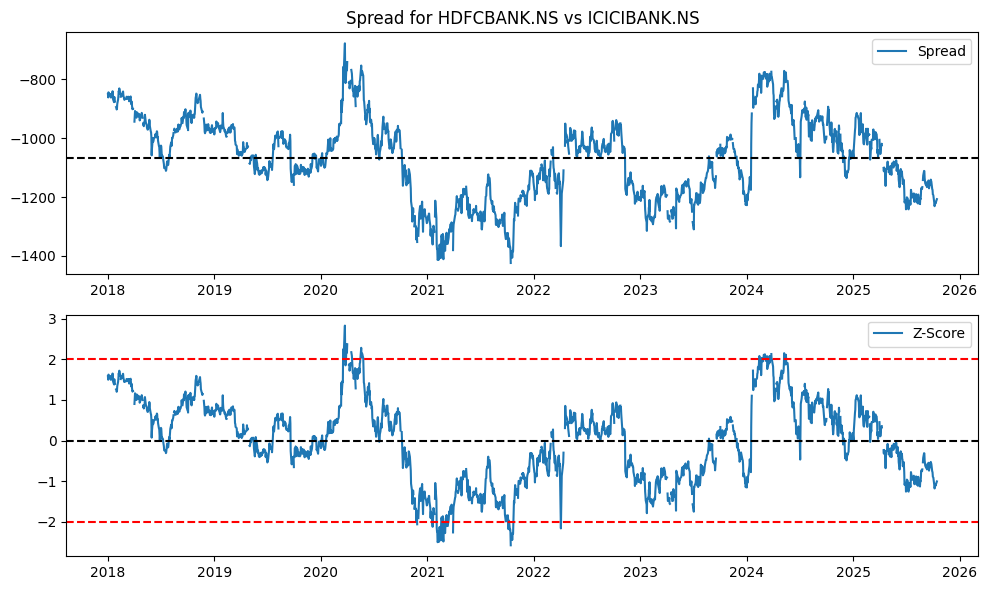

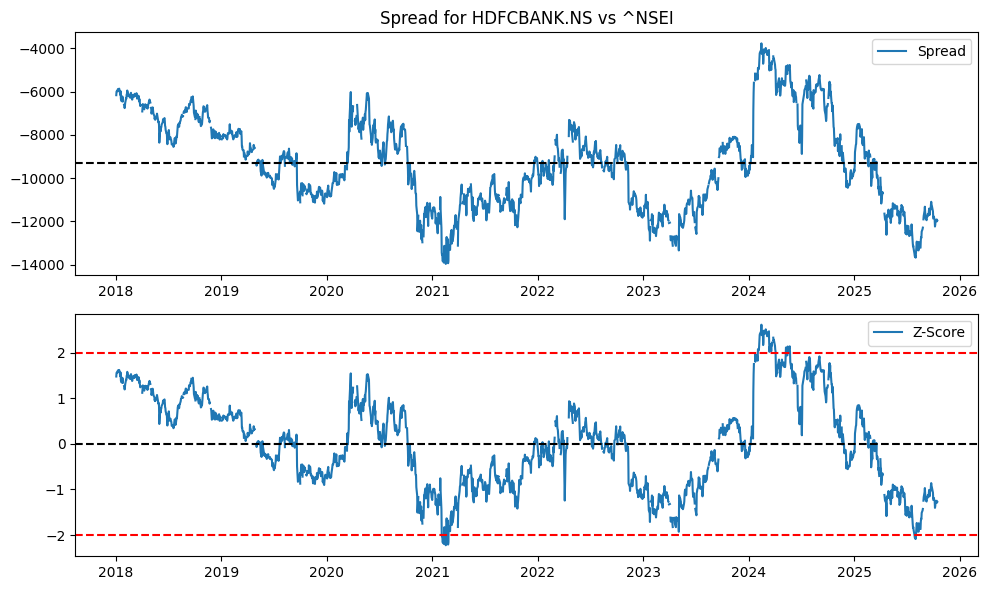

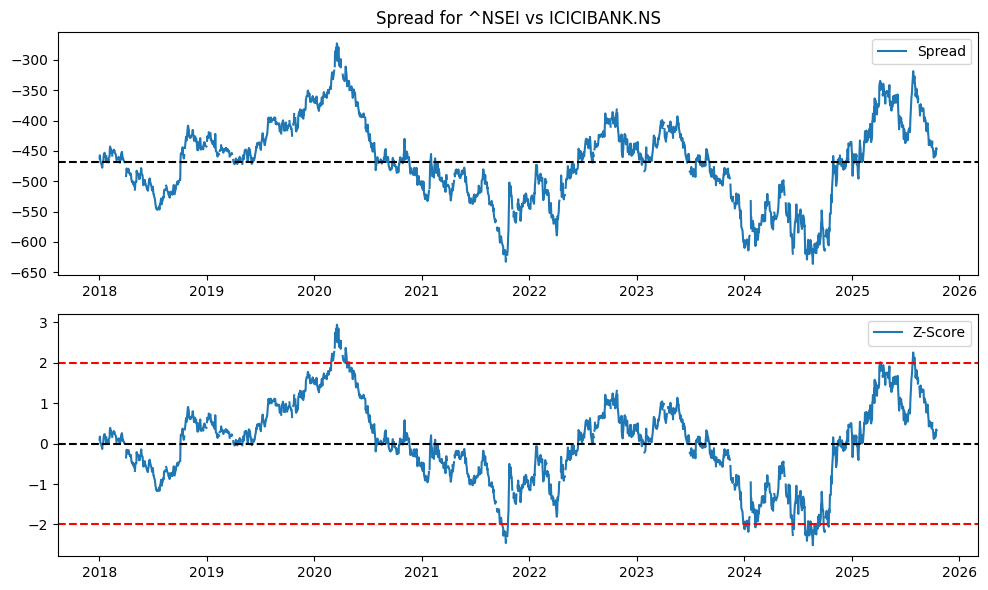

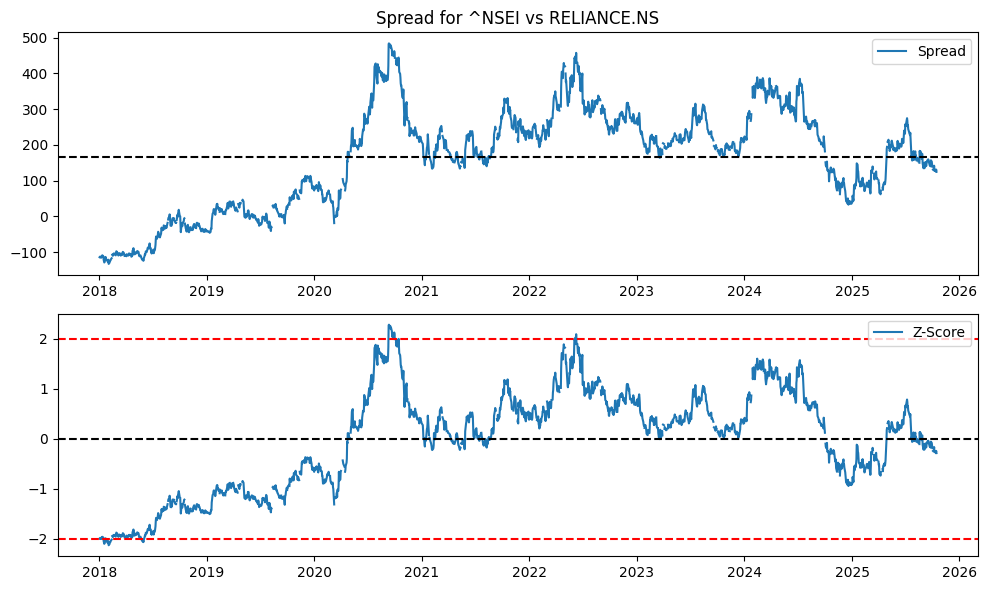

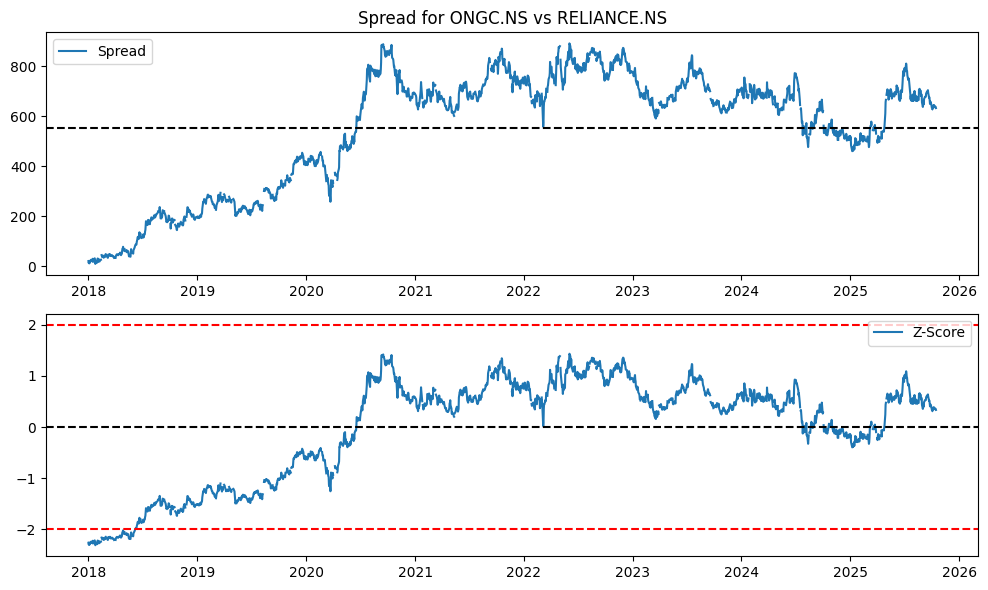

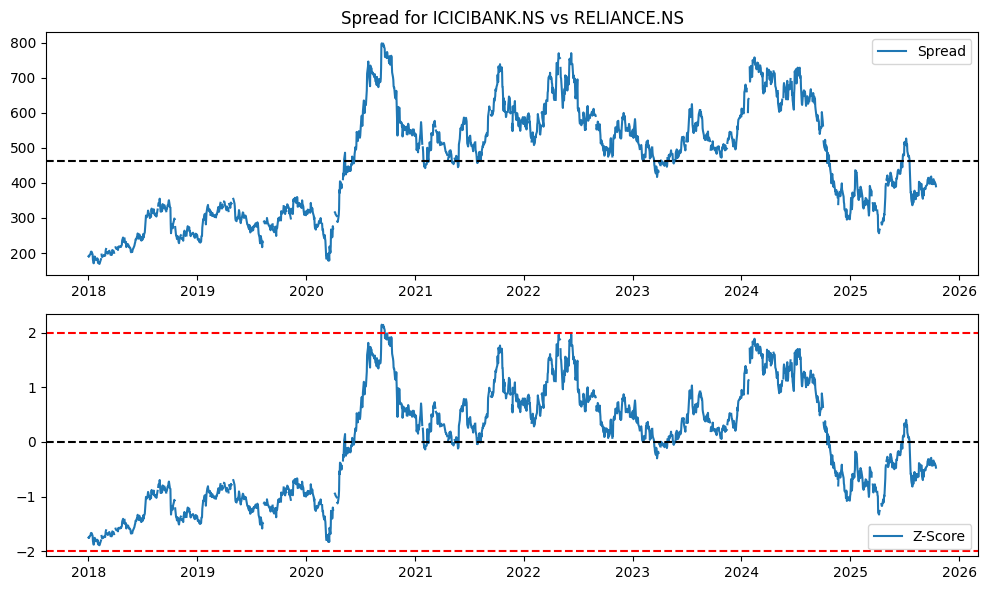

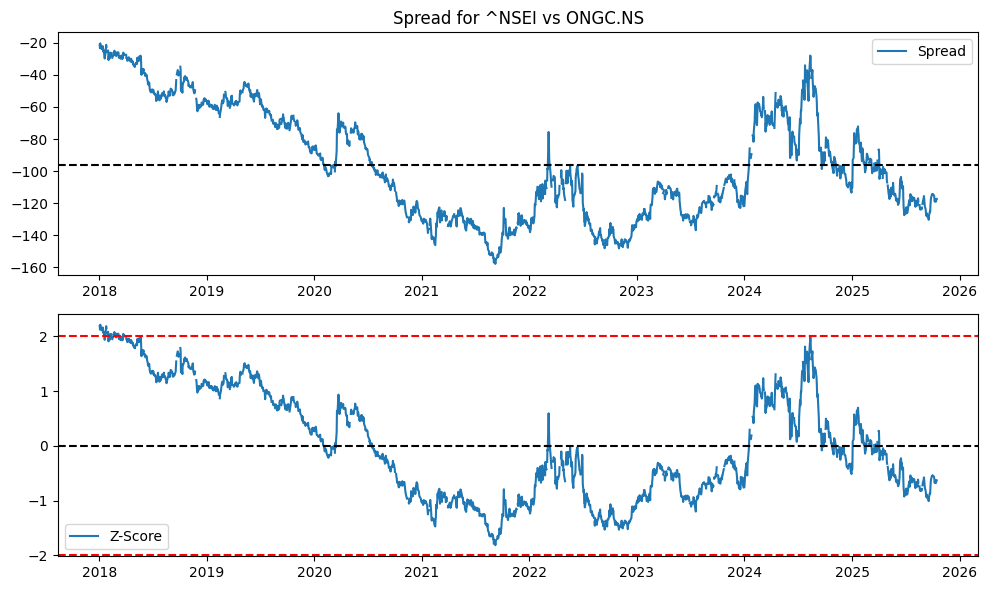

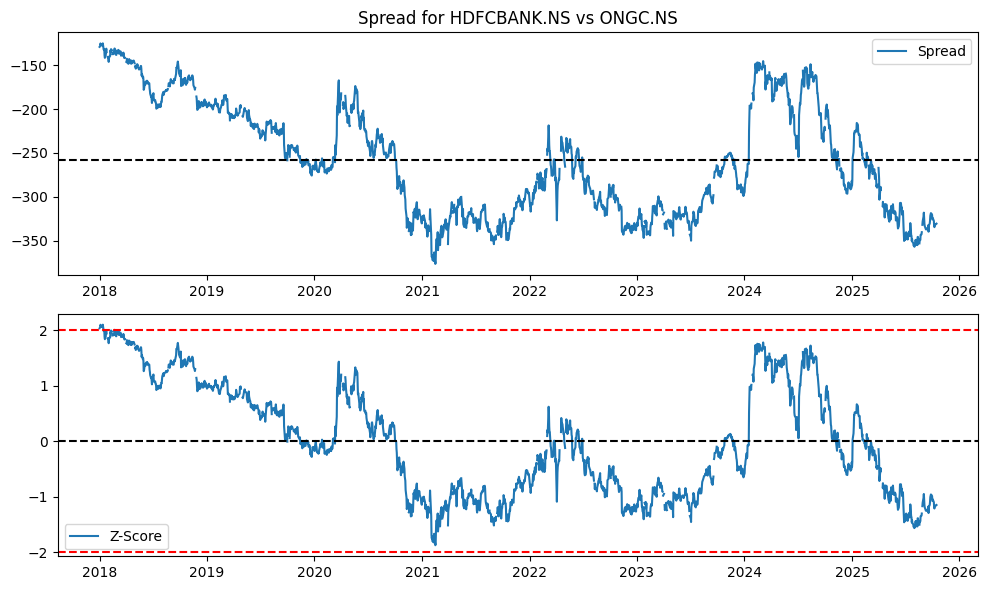

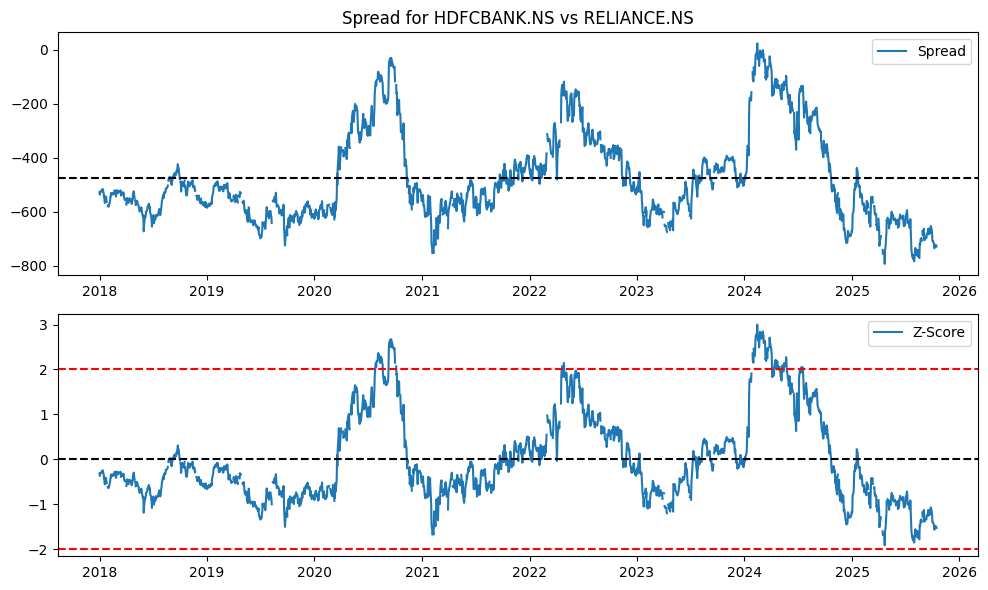

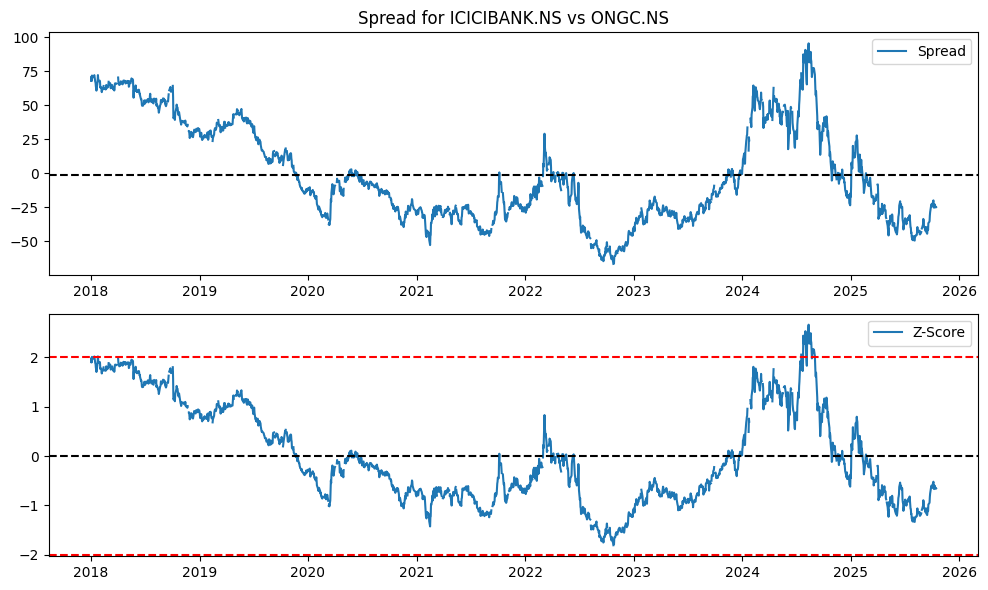

In [7]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

def estimate_half_life(spread):
    """
    Estimate half-life of mean reversion for a stationary series.
    Uses discrete-time approximation of Ornstein-Uhlenbeck process.
    """
    spread = pd.Series(spread).dropna()
    spread_lag = spread.shift(1).dropna()
    delta = spread.diff().dropna()

    X = sm.add_constant(spread_lag.loc[delta.index])
    model = sm.OLS(delta.loc[delta.index], X).fit()

    # --- Fix: safely extract coefficient for lag term ---
    phi = model.params.iloc[1] if len(model.params) > 1 else 0.0

    #phi = model.params.get('x1', list(model.params.values())[1] if len(model.params)>1 else 0)

    if phi >= 0:
        return np.inf  # not mean-reverting
    half_life = -np.log(2) / phi
    return half_life

# ===========================================
# 📘 Add ADF + Half-Life Analysis
# ===========================================

augmented_rows = []

for _, r in summary_johansen_df.iterrows():
    if ('error' in r and pd.notna(r['error'])) or not (r['cointegrated_trace'] or r['cointegrated_maxeig']):
        # Skip non-cointegrated pairs
        augmented_rows.append(r)
        continue

    a, b = r['pair']
    df_pair = prices[[a, b]].dropna()

    # Recreate normalized cointegrating vector
    beta_y = r['beta_y_normalized']
    spread = beta_y * df_pair[a] + df_pair[b]

    # --- ADF test on spread
    adf_res = adfuller(spread, regression='c', autolag='AIC')
    adf_stat, adf_pval = adf_res[0], adf_res[1]
    crit_vals = adf_res[4]
    stationary = adf_pval < 0.05

    # --- Half-life estimation
    half_life = estimate_half_life(spread)

    # --- Example thresholds
    zscore = (spread - spread.mean()) / spread.std()
    entry_long = spread.mean() - 2 * spread.std()
    entry_short = spread.mean() + 2 * spread.std()
    exit_level = spread.mean()

    # Add to row
    augmented_rows.append({
        **r,
        'ADF_stat': round(adf_stat, 4),
        'ADF_pval': round(adf_pval, 4),
        'ADF_stationary': stationary,
        'Half_life_days': None if np.isinf(half_life) else round(half_life, 2),
        'Entry_long': round(entry_long, 2),
        'Entry_short': round(entry_short, 2),
        'Exit_mean': round(exit_level, 2)
    })

summary_johansen_df = pd.DataFrame(augmented_rows)

# Order columns nicely
cols = [
    'pair','eig1','trace_stat_r0','trace_crit95_r0','maxeig_stat_r0','maxeig_crit95_r0',
    'cointegrated_trace','cointegrated_maxeig',
    'ADF_stat','ADF_pval','ADF_stationary','Half_life_days',
    'Entry_long','Exit_mean','Entry_short','beta_y_normalized','notes'
]
summary_johansen_df = summary_johansen_df[[c for c in cols if c in summary_johansen_df.columns]]

# Sort and display
summary_johansen_df = summary_johansen_df.sort_values('eig1', ascending=False).reset_index(drop=True)
#display(summary_johansen_df)

def plot_spread_zscore(pair, spread):
    z = (spread - spread.mean()) / spread.std()
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(spread, label='Spread')
    plt.axhline(spread.mean(), color='black', linestyle='--')
    plt.title(f"Spread for {pair[0]} vs {pair[1]}")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(z, label='Z-Score')
    plt.axhline(2, color='red', linestyle='--')
    plt.axhline(-2, color='red', linestyle='--')
    plt.axhline(0, color='black', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot for cointegrated & stationary pairs
for _, r in summary_johansen_df.iterrows():
    if r.get('ADF_stationary'):
        a, b = r['pair']
        spread = r['beta_y_normalized'] * prices[a] + prices[b]
        plot_spread_zscore((a,b), spread)


## 7) Next steps (practical roadmap)

1. **Confirm scaling & normalization**  
   - Recompute cointegrating vectors using *log-prices* and/or standardize series (divide by mean price) to see if `beta` magnitudes stabilize.

2. **Robustness sweep**  
   - Re-run Johansen for the two top pairs across `det_order = -1, 0, 1` and `k_ar_diff` ∈ {1..5} (or BIC) and record agreement rate. If >80% of configurations still show cointegration → higher confidence.

3. **Spread stationarity tests**  
   - Compute spread for each candidate; run ADF, KPSS on spread; report p-values and stationarity conclusion.

4. **Visual + statistical regime checks**  
   - Plot spread with rolling moments; run Bai-Perron or structural-break detection (or at least compare pre/post sample behavior).

5. **Backtest simple strategy**  
   - For top pair(s): z-score entry at ±2σ, exit at 0σ, cap max holding days, include transaction costs and slippage; compute Sharpe, max drawdown, avg holding time.

6. **Risk / execution**  
   - Determine realistic position sizing, correlation with portfolio, and shortability/liquidity of instruments (some tickers may have different liquidity).

7. **If results remain promising**  
   - Implement paper-trading or live small-size testing with monitoring for regime shifts.

---